# Training a Random Forest Classifier to Predict Cryptocurrency Direction

This notebook focuses on training a Random Forest classifier to predict the direction of Bitcoin price (up or down). The model is trained and evaluated to predict future price movements, with a focus on improving accuracy, particularly for downturn predictions.

## Import Libraries

In [250]:
%pip install yfinance matplotlib scikit-learn seaborn ta

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\tutorials\technical_analysis\random_forest_bitcoin_price_prediction\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
import ta

plt.style.use('dark_background')

## Data

### Download

In [ ]:
data = yf.download("BTC-USD", start="2010-09-17", end="2025-05-19", auto_adjust=True)
data.head()

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


In [253]:
data.columns = data.columns.get_level_values(0)
data = data[['Open', 'Close', 'Volume', 'Low', 'High']]

### Plot Closing Price Chart

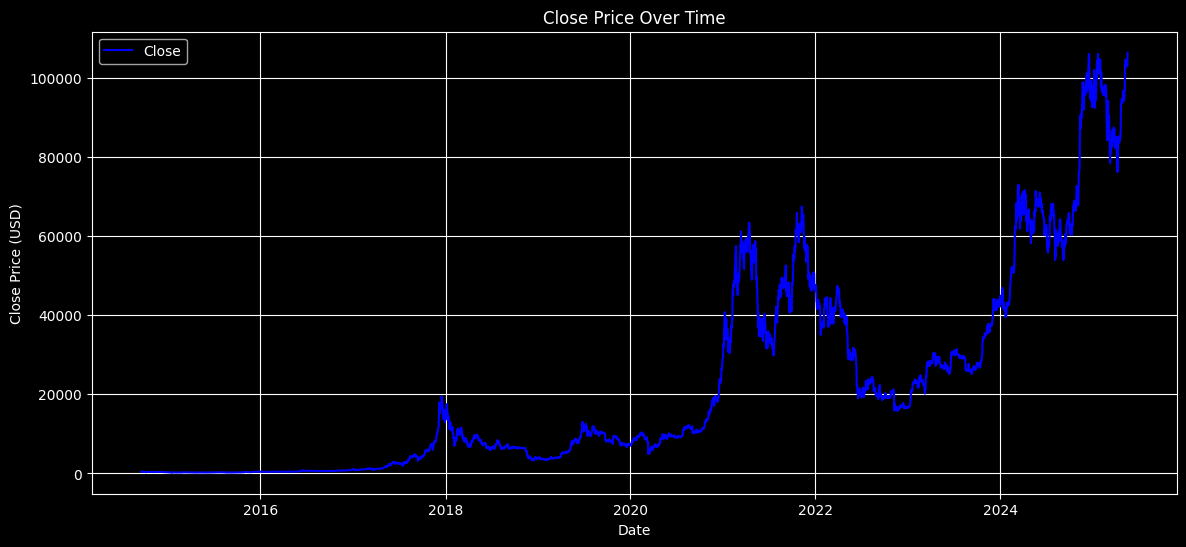

In [280]:
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Close'], label='Close', color='blue')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.savefig("Close.png")
plt.show()

#### Close

## Creating the Target Variable: Market Direction

This cell defines the **target variable `Direction`**, which indicates whether the Bitcoin's closing price will increase in the next time step. It assigns:
- `1` if the next closing price is **higher** than the current one (uptrend)
- `0` otherwise (downtrend)

It then removes any rows with missing values resulting from the `shift(-1)` operation.


In [260]:
data["Direction"] = (data["Close"].shift(-1) > data["Close"]).astype(int)
data.dropna(inplace=True)

## Feature Engineering

### Percentage Returns

In [261]:
data["Return_1d"] = data["Close"].pct_change()
data["Return_3d"] = data["Close"].pct_change(3)
data["Return_7d"] = data["Close"].pct_change(7)

### Price Range and Volatility

In [262]:
data["High_Low"] = data["High"] - data["Low"]
data["Close_Open"] = data["Close"] - data["Open"]
data["Volatility_7d"] = data["Close"].rolling(7).std()

### Moving Averages

In [263]:
data["MA_5"] = data["Close"].rolling(window=5).mean()
data["MA_10"] = data["Close"].rolling(window=10).mean()
data["MA_ratio"] = data["MA_5"] / data["MA_10"]

### RSI (Relative Strength Index)

In [264]:
data["RSI"] = ta.momentum.RSIIndicator(data["Close"]).rsi()

### MACD (Moving Average Convergence Divergence)

In [265]:
macd = ta.trend.MACD(data["Close"])
data["MACD"] = macd.macd()
data["MACD_signal"] = macd.macd_signal()

### Volume Based Features

In [266]:
data["Volume_Change"] = data["Volume"].pct_change()
data["Volume_MA_5"] = data["Volume"].rolling(5).mean()

### Lag Features

In [267]:
for lag in range(1, 4):
    data[f"Close_lag_{lag}"] = data["Close"].shift(lag)
    data[f"Volume_lag_{lag}"] = data["Volume"].shift(lag)


### Datetime Features

In [268]:
data["DayOfWeek"] = data.index.dayofweek  # Monday=0, Sunday=6
data["Month"] = data.index.month

### Rolling Statistics & Momentum Indicators

In [269]:
data["Momentum_10"] = data["Close"] - data["Close"].shift(10)
data["Rolling_Max_10"] = data["Close"].rolling(10).max()
data["Rolling_Min_10"] = data["Close"].rolling(10).min()

In [270]:
data.dropna(inplace=True)

In [271]:
# Feature Matrix and Target
X = data.drop(columns=["Direction"])
y = data["Direction"]

## Feature Selection

In [272]:
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X, y)

### Plot Feature Importance from SelectKBest

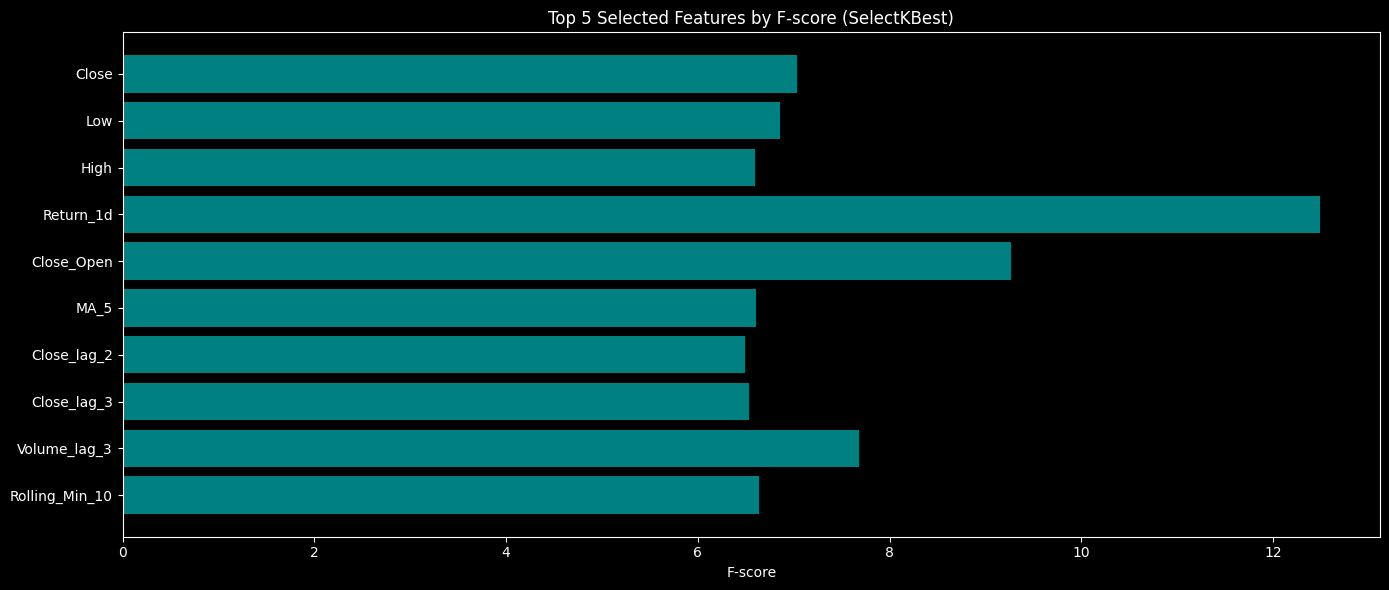

In [273]:
# Get scores and mask of selected features
scores = selector.scores_
selected_mask = selector.get_support()  # boolean mask of selected features
selected_feature_names = X.columns[selected_mask]

# Plot
plt.figure(figsize=(14, 6))
plt.barh(selected_feature_names, scores[selected_mask], color="teal")
plt.xlabel("F-score")
plt.title("Top 5 Selected Features by F-score (SelectKBest)")
plt.gca().invert_yaxis()  # optional: put highest on top
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()

## Train a Random Forest

### Split the data into train-test set

In [274]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, shuffle=False
)

In [275]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

## Evaluation

### Classification Report

In [276]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.78      0.62       380
           1       0.57      0.28      0.38       393

    accuracy                           0.53       773
   macro avg       0.54      0.53      0.50       773
weighted avg       0.54      0.53      0.50       773



### Predicted Market Direction

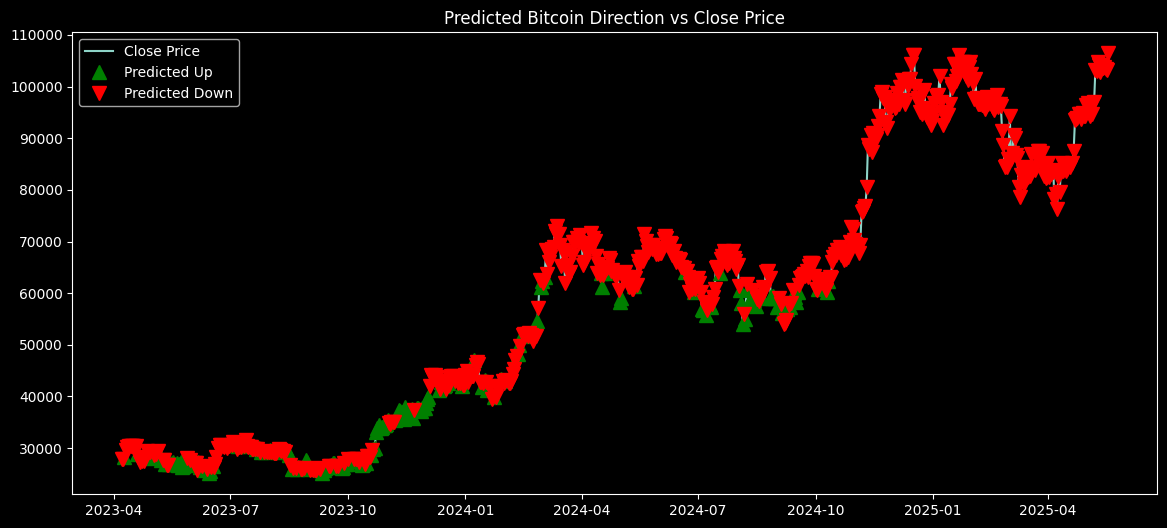

In [277]:
plt.figure(figsize=(14,6))
plt.plot(data.index[-len(y_test):], data["Close"][-len(y_test):], label='Close Price')
plt.plot(data.index[-len(y_test):][y_pred == 1], data["Close"][-len(y_test):][y_pred == 1], '^', markersize=10, color='g', label='Predicted Up')
plt.plot(data.index[-len(y_test):][y_pred == 0], data["Close"][-len(y_test):][y_pred == 0], 'v', markersize=10, color='r', label='Predicted Down')
plt.title("Predicted Bitcoin Direction vs Close Price")
plt.legend()
plt.savefig("predicted_market_direction.png")
plt.show()

### Confusion Matrix

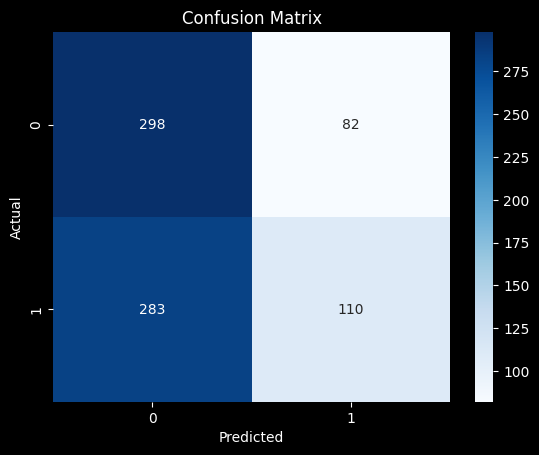

In [278]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")
plt.show()